# Alzheimer's Simulation: Scenario Comparison Over Time

This notebook runs all three scenarios (baseline, bbbm_testing, bbbm_testing_and_treatment)
and collects snapshots at every time step to visualize how disease states, testing, and
treatment evolve over time.

### Scenarios
| Scenario | BBBM Testing | Treatment |
|---|---|---|
| `baseline` | No | No |
| `bbbm_testing` | Yes | No |
| `bbbm_testing_and_treatment` | Yes | Yes |

In [1]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm.auto import tqdm
from vivarium import InteractiveContext

SPEC_PATH = '../src/vivarium_csu_alzheimers/model_specifications/model_spec.yaml'
POPULATION_SIZE = 10_000
STEP_SIZE_DAYS = 182

BBBM_STATE = 'alzheimers_blood_based_biomarker_state'
MCI_STATE = 'alzheimers_mild_cognitive_impairment_state'
DEMENTIA_STATE = 'alzheimers_disease_state'
DISEASE_COL = 'alzheimers_disease_and_other_dementias'

SCENARIOS = ['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
SCENARIO_LABELS = {
    'baseline': 'Baseline',
    'bbbm_testing': 'Testing Only',
    'bbbm_testing_and_treatment': 'Testing + Treatment',
}
SCENARIO_COLORS = {
    'baseline': '#1f77b4',
    'bbbm_testing': '#ff7f0e',
    'bbbm_testing_and_treatment': '#2ca02c',
}

TARGET_YEAR = 2060  # how far to run the simulation

## Collect snapshots

Run each scenario from 2022 to the target year, collecting population snapshots at every
time step. This takes several minutes per scenario.

In [2]:
def collect_snapshots(scenario, target_year=TARGET_YEAR):
    """Run a scenario and collect summary stats at each time step."""
    sim = InteractiveContext(
        SPEC_PATH,
        configuration={
            'population': {'population_size': POPULATION_SIZE},
            'intervention': {'scenario': scenario},
        }
    )
    target = pd.Timestamp(f'{target_year}-01-01')
    est_steps = max(1, math.ceil((target - sim.current_time).days / STEP_SIZE_DAYS))
    snapshots = []

    with tqdm(total=est_steps, desc=SCENARIO_LABELS[scenario], unit='step') as pbar:
        while sim.current_time < target:
            sim.step()
            pop = sim.get_population()
            alive = pop[pop['alive'] == 'alive']
            disease = alive[DISEASE_COL].value_counts()

            # Testing stats
            eligible_mask = (
                (alive[DISEASE_COL] == BBBM_STATE)
                & (alive['age'] >= 65) & (alive['age'] < 80)
                & (alive['bbbm_test_result'] != 'positive')
            )
            n_eligible = int(eligible_mask.sum())
            n_bbbm_tested = int(alive['bbbm_test_date'].notna().sum()) if 'bbbm_test_date' in alive.columns else 0
            n_positive = int((alive['bbbm_test_result'] == 'positive').sum())

            # Treatment stats
            active_treat = ['waiting_for_treatment', 'treatment_effect',
                            'waning_effect', 'no_effect_after_treatment']
            n_in_treatment = int(alive['treatment'].isin(active_treat).sum())
            n_treatment_effect = int((alive['treatment'] == 'treatment_effect').sum())

            snap = {
                'time': sim.current_time,
                'year': sim.current_time.year + sim.current_time.day_of_year / 365.25,
                'n_alive': len(alive),
                'n_bbbm': disease.get(BBBM_STATE, 0),
                'n_mci': disease.get(MCI_STATE, 0),
                'n_dementia': disease.get(DEMENTIA_STATE, 0),
                'n_eligible': n_eligible,
                'n_bbbm_tested': n_bbbm_tested,
                'n_positive': n_positive,
                'n_in_treatment': n_in_treatment,
                'n_treatment_effect': n_treatment_effect,
            }
            snapshots.append(snap)
            pbar.update(1)
        pbar.total = len(snapshots)
        pbar.refresh()

    return pd.DataFrame(snapshots)

In [3]:
data = {}
for scenario in SCENARIOS:
    data[scenario] = collect_snapshots(scenario)
    print(f'  {SCENARIO_LABELS[scenario]}: {len(data[scenario])} steps collected')
print('\nAll scenarios complete.')

2026-02-07 15:17:01.112 | INFO     | simulation_1-artifact_manager:79 - Running simulation from artifact located at /home/abie/vivarium_csu_alzheimers/united_states_of_america.hdf.
2026-02-07 15:17:01.115 | INFO     | simulation_1-artifact_manager:80 - Artifact base filter terms are ['draw == 0'].
2026-02-07 15:17:01.117 | INFO     | simulation_1-artifact_manager:81 - Artifact additional filter terms are None.


/home/abie/miniforge3/envs/vivarium_csu_alzheimers_simulation/lib/python3.11/site-packages/vivarium_public_health/plugins/parser.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


2026-02-07 15:17:02.449 | INFO     | simulation_1-results_context:129 - The following stratifications are registered but not used by any observers: 
['current_year', 'semester']
2026-02-07 15:17:02.575 | WARNING  | simulation_1-resource_manager:176 - Resource stream.alzheimers_disease_and_other_dementias_initial_states is not produced by any component but is needed to compute (column.alzheimers_disease_and_other_dementias).
2026-02-07 15:17:02.577 | WARNING  | simulation_1-resource_manager:176 - Resource column.treatment_effect.dwell_time is not produced by any component but is needed to compute (value_modifier.treatment_effect.dwell_time.1.treatment.modify_dwell_time).
2026-02-07 15:17:02.578 | WARNING  | simulation_1-resource_manager:176 - Resource column.waning_effect.dwell_time is not produced by any component but is needed to compute (value_modifier.waning_effect.dwell_time.1.treatment.modify_dwell_time).
2026-02-07 15:17:02.579 | WARNING  | simulation_1-resource_manager:176 - Res

Baseline:   0%|          | 0/77 [00:00<?, ?step/s]

2026-02-07 15:17:03.678 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2022-01-01 00:00:00
2026-02-07 15:17:07.949 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2022-07-02 00:00:00
2026-02-07 15:17:12.745 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2022-12-31 00:00:00
2026-02-07 15:17:17.959 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2023-07-01 00:00:00
2026-02-07 15:17:21.219 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2023-12-30 00:00:00
2026-02-07 15:17:25.232 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2024-06-29 00:00:00
2026-02-07 15:17:33.565 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2024-12-28 00:00:00
2026-02-07 15:17:38.519 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-06-28 00:00:00
2026-02-07 15:17:44.574 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-12-27 00:00:00
2026-02-07 15:17:50.923 | INFO     | simulation_1 - vivarium.fra

Testing Only:   0%|          | 0/77 [00:00<?, ?step/s]

2026-02-07 15:28:01.115 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2022-01-01 00:00:00
2026-02-07 15:28:05.447 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2022-07-02 00:00:00
2026-02-07 15:28:10.842 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2022-12-31 00:00:00
2026-02-07 15:28:15.415 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2023-07-01 00:00:00
2026-02-07 15:28:19.901 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2023-12-30 00:00:00
2026-02-07 15:28:25.258 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2024-06-29 00:00:00
2026-02-07 15:28:28.936 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2024-12-28 00:00:00
2026-02-07 15:28:36.234 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-06-28 00:00:00
2026-02-07 15:28:44.818 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-12-27 00:00:00
2026-02-07 15:28:51.695 | INFO     | simulation_2 - vivarium.fra

Testing + Treatment:   0%|          | 0/77 [00:00<?, ?step/s]

2026-02-07 15:39:37.643 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2022-01-01 00:00:00
2026-02-07 15:39:42.684 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2022-07-02 00:00:00
2026-02-07 15:39:47.415 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2022-12-31 00:00:00
2026-02-07 15:39:52.137 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2023-07-01 00:00:00
2026-02-07 15:39:59.203 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2023-12-30 00:00:00
2026-02-07 15:40:04.143 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2024-06-29 00:00:00
2026-02-07 15:40:09.827 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2024-12-28 00:00:00
2026-02-07 15:40:15.343 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2025-06-28 00:00:00
2026-02-07 15:40:21.059 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2025-12-27 00:00:00
2026-02-07 15:40:26.433 | INFO     | simulation_3 - vivarium.fra

---
## Disease State Trajectories

How the number of simulants in each disease state evolves over time, across scenarios.

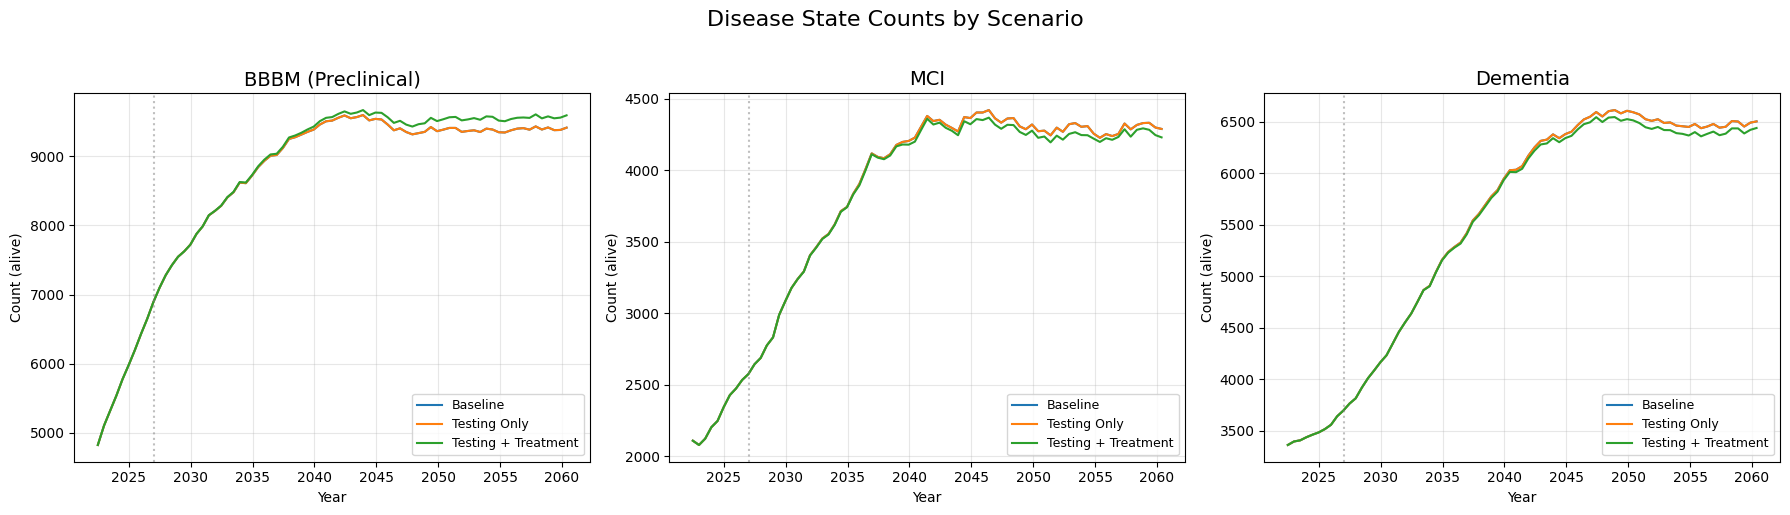

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
state_cols = [('n_bbbm', 'BBBM (Preclinical)'), ('n_mci', 'MCI'), ('n_dementia', 'Dementia')]

for ax, (col, title) in zip(axes, state_cols):
    for scenario in SCENARIOS:
        df = data[scenario]
        ax.plot(df['year'], df[col],
                label=SCENARIO_LABELS[scenario],
                color=SCENARIO_COLORS[scenario], linewidth=1.5)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Year')
    ax.set_ylabel('Count (alive)')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.axvline(x=2027, color='gray', linestyle=':', alpha=0.5, label='Testing starts')

fig.suptitle('Disease State Counts by Scenario', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Differences from Baseline

Plot the difference in disease state counts relative to baseline. This isolates the
effect of testing and treatment interventions.

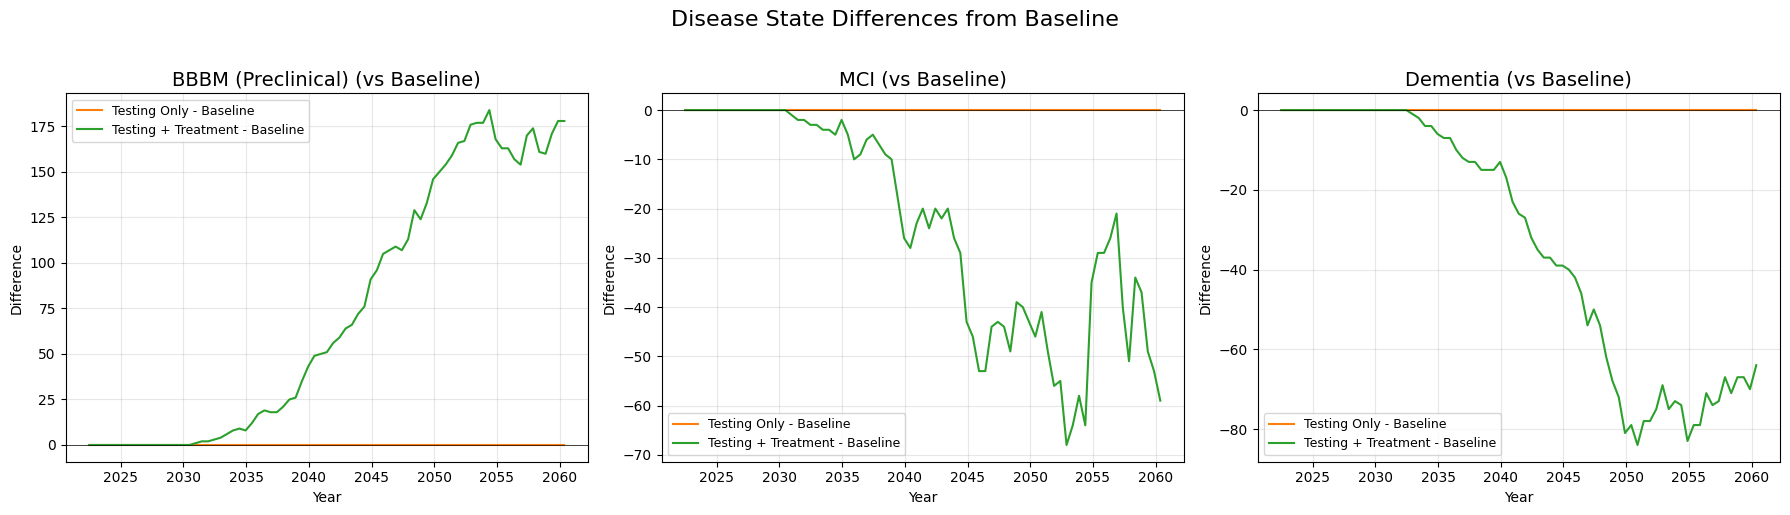

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

baseline_df = data['baseline']
for ax, (col, title) in zip(axes, state_cols):
    for scenario in ['bbbm_testing', 'bbbm_testing_and_treatment']:
        df = data[scenario]
        # Align on the shorter length in case of minor step count differences
        n = min(len(df), len(baseline_df))
        diff = df[col].iloc[:n].values - baseline_df[col].iloc[:n].values
        ax.plot(df['year'].iloc[:n], diff,
                label=f'{SCENARIO_LABELS[scenario]} - Baseline',
                color=SCENARIO_COLORS[scenario], linewidth=1.5)
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.set_title(f'{title} (vs Baseline)', fontsize=14)
    ax.set_xlabel('Year')
    ax.set_ylabel('Difference')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

fig.suptitle('Disease State Differences from Baseline', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Testing Coverage Over Time

Cumulative BBBM-positive tests and eligible population size.

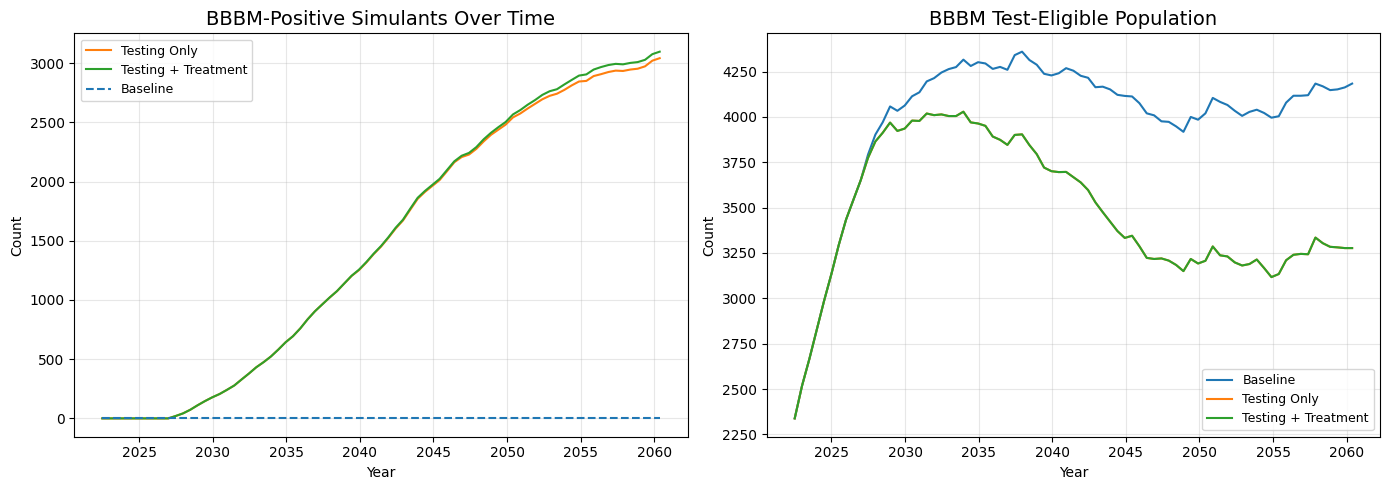

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Cumulative BBBM-positive tests
ax = axes[0]
for scenario in ['bbbm_testing', 'bbbm_testing_and_treatment']:
    df = data[scenario]
    ax.plot(df['year'], df['n_positive'],
            label=SCENARIO_LABELS[scenario],
            color=SCENARIO_COLORS[scenario], linewidth=1.5)
bl_df = data['baseline']
ax.plot(bl_df['year'], bl_df['n_positive'],
        label=SCENARIO_LABELS['baseline'],
        color=SCENARIO_COLORS['baseline'], linewidth=1.5, linestyle='--')
ax.set_title('BBBM-Positive Simulants Over Time', fontsize=14)
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Right: Eligible for BBBM testing
ax = axes[1]
for scenario in SCENARIOS:
    df = data[scenario]
    ax.plot(df['year'], df['n_eligible'],
            label=SCENARIO_LABELS[scenario],
            color=SCENARIO_COLORS[scenario], linewidth=1.5)
ax.set_title('BBBM Test-Eligible Population', fontsize=14)
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Treatment Activity Over Time

Number of simulants in the treatment pipeline and actively receiving treatment effect.

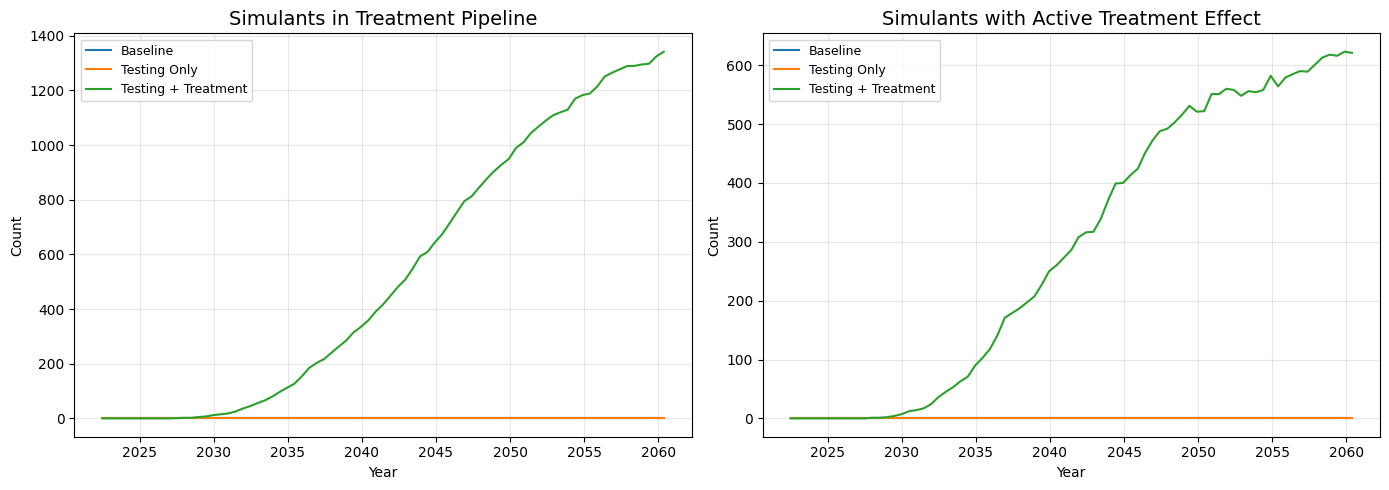

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: In treatment pipeline (any non-susceptible treatment state)
ax = axes[0]
for scenario in SCENARIOS:
    df = data[scenario]
    ax.plot(df['year'], df['n_in_treatment'],
            label=SCENARIO_LABELS[scenario],
            color=SCENARIO_COLORS[scenario], linewidth=1.5)
ax.set_title('Simulants in Treatment Pipeline', fontsize=14)
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Right: Actively receiving treatment effect
ax = axes[1]
for scenario in SCENARIOS:
    df = data[scenario]
    ax.plot(df['year'], df['n_treatment_effect'],
            label=SCENARIO_LABELS[scenario],
            color=SCENARIO_COLORS[scenario], linewidth=1.5)
ax.set_title('Simulants with Active Treatment Effect', fontsize=14)
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Disease State Proportions Over Time

Stacked area charts showing the fraction of alive simulants in each disease state.

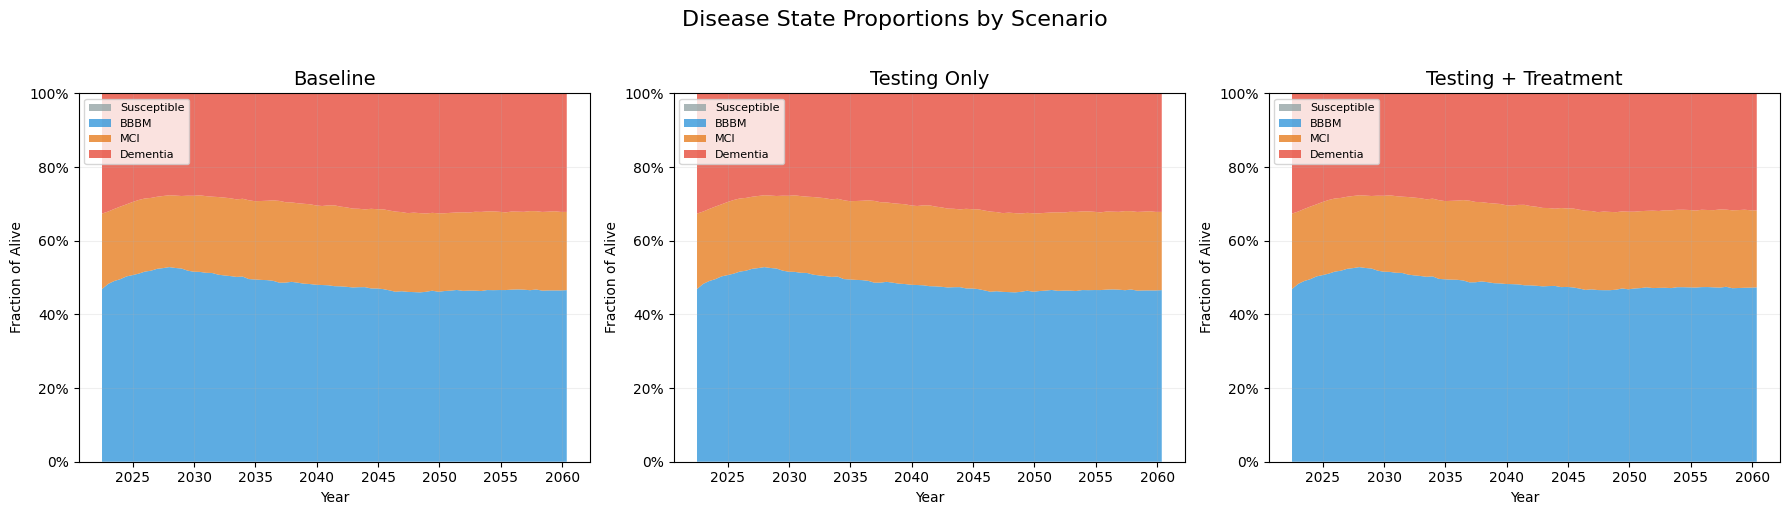

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
state_colors = {'BBBM': '#3498db', 'MCI': '#e67e22', 'Dementia': '#e74c3c', 'Susceptible': '#95a5a6'}

for ax, scenario in zip(axes, SCENARIOS):
    df = data[scenario]
    total = df['n_alive']
    bbbm_frac = df['n_bbbm'] / total
    mci_frac = df['n_mci'] / total
    dem_frac = df['n_dementia'] / total
    other_frac = 1.0 - bbbm_frac - mci_frac - dem_frac

    ax.stackplot(df['year'],
                 other_frac, bbbm_frac, mci_frac, dem_frac,
                 labels=['Susceptible', 'BBBM', 'MCI', 'Dementia'],
                 colors=[state_colors['Susceptible'], state_colors['BBBM'],
                         state_colors['MCI'], state_colors['Dementia']],
                 alpha=0.8)
    ax.set_title(SCENARIO_LABELS[scenario], fontsize=14)
    ax.set_xlabel('Year')
    ax.set_ylabel('Fraction of Alive')
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.2)

fig.suptitle('Disease State Proportions by Scenario', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Animated Disease Progression

Bar chart animation showing disease state counts across all three scenarios at each time point.
The animation is saved as an HTML5 video embedded in the notebook.

In [9]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Determine frame count from shortest scenario
n_frames = min(len(data[s]) for s in SCENARIOS)
# Subsample to keep animation manageable (every 2nd frame)
frame_indices = list(range(0, n_frames, 2))

fig, ax = plt.subplots(figsize=(10, 6))
states_short = ['BBBM', 'MCI', 'Dementia']
state_keys = [BBBM_STATE, MCI_STATE, DEMENTIA_STATE]
x = np.arange(len(states_short))
width = 0.25

bars = {}
for i, scenario in enumerate(SCENARIOS):
    bars[scenario] = ax.bar(x + i * width, [0] * len(states_short), width,
                            label=SCENARIO_LABELS[scenario],
                            color=SCENARIO_COLORS[scenario], alpha=0.85)

ax.set_xticks(x + width)
ax.set_xticklabels(states_short, fontsize=12)
ax.set_ylabel('Count (alive)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, axis='y', alpha=0.3)
title = ax.set_title('', fontsize=14)

# Find global y-max for consistent axis
y_max = max(
    data[s][['n_bbbm', 'n_mci', 'n_dementia']].max().max()
    for s in SCENARIOS
) * 1.1
ax.set_ylim(0, y_max)

def update(frame_idx):
    i = frame_indices[frame_idx]
    year_str = f"{data['baseline']['year'].iloc[i]:.1f}"
    title.set_text(f'Disease State Counts  |  Year {year_str}')
    for scenario in SCENARIOS:
        df = data[scenario]
        vals = [df['n_bbbm'].iloc[i], df['n_mci'].iloc[i], df['n_dementia'].iloc[i]]
        for bar, val in zip(bars[scenario], vals):
            bar.set_height(val)
    return [b for group in bars.values() for b in group]

ani = FuncAnimation(fig, update, frames=len(frame_indices), interval=200, blit=False)
plt.close(fig)
HTML(ani.to_html5_video())

## Summary Table at Key Years

In [10]:
key_years = [2030, 2035, 2040, 2045, 2050, 2055]
rows = []
for scenario in SCENARIOS:
    df = data[scenario]
    for target_year in key_years:
        # Find the row closest to Jan 1 of the target year
        idx = (df['year'] - target_year).abs().idxmin()
        row = df.iloc[idx]
        rows.append({
            'Scenario': SCENARIO_LABELS[scenario],
            'Year': target_year,
            'Alive': int(row['n_alive']),
            'BBBM': int(row['n_bbbm']),
            'MCI': int(row['n_mci']),
            'Dementia': int(row['n_dementia']),
            'BBBM+': int(row['n_positive']),
            'In Treatment': int(row['n_in_treatment']),
        })

summary = pd.DataFrame(rows)
summary = summary.set_index(['Year', 'Scenario'])
print(summary.to_string())

                          Alive  BBBM   MCI  Dementia  BBBM+  In Treatment
Year Scenario                                                             
2030 Baseline             14968  7720  3085      4163      0             0
2035 Baseline             17621  8718  3744      5159      0             0
2040 Baseline             19534  9383  4206      5945      0             0
2045 Baseline             20284  9538  4366      6380      0             0
2050 Baseline             20287  9360  4321      6606      0             0
2055 Baseline             20051  9345  4257      6449      0             0
2030 Testing Only         14968  7720  3085      4163    178             0
2035 Testing Only         17621  8718  3744      5159    643             0
2040 Testing Only         19534  9383  4206      5945   1252             0
2045 Testing Only         20284  9538  4366      6380   1963             0
2050 Testing Only         20287  9360  4321      6606   2481             0
2055 Testing Only        